In [1]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from typing import List, Callable
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import random
import math


NUM_COURIERS = 15  # Количество курьеров

In [2]:
"""
Contains described models.
"""

from typing import List
import numpy as np
import abc
import json
import dataclasses


@dataclasses.dataclass
class Coordinates:
    """
    Сласс координаты
    Attributes:
       lon: Долгота.
       lat: Широта.
    """

    lon: float
    lat: float

    def __add__(self, coord: "Coordinates") -> "Coordinates":
        return Coordinates(self.lon + coord.lon, self.lat + coord.lat)

    def __sub__(self, coord: "Coordinates") -> "Coordinates":
        return Coordinates(self.lon - coord.lon, self.lat - coord.lat)

    def __mul__(self, m):
        return Coordinates(self.lon * m, self.lat * m)

    def __truediv__(self, d):
        return Coordinates(self.lon / d, self.lat / d)

    def __iter__(self):
        return iter((self.lon, self.lat))


@dataclasses.dataclass
class Scooter(Coordinates):
    """
    Attributes:
        lat: Широта.
        lon: Долгота.
        priority: Приоритет самоката.
    """

    priority: int

    @classmethod
    def from_(cls, x=0, y=0, p=0):
        return cls(lat=x, lon=y, priority=p)

    @classmethod
    def from_dict(cls, data: dict) -> "Scooter":
        return cls(priority=data["priority"], position=Coordinates(*data["position"]))


@dataclasses.dataclass
class Request:
    """
    Класс для обработки данных.

    Attributes:
        capacity: Допустимое количество точек в маршруте.
        penalty: Штраф за одну минуту маршрута.
        scooters: Координаты и приоритет самокатов.
        time: Допустимая продолжительность маршрута.
        time_matrix: Матрица временных затрат на перемещение между точками.
    """

    capacity: int
    penalty: int
    scooters: List[Scooter]
    time: int
    time_matrix: List[List[int]]

    @property
    def points_number(self) -> int:
        return len(self.scooters)

    @property
    def scooter_number(self) -> int:
        return self.points_number - 1

    @property
    def M(self) -> int:
        return self.time_matrix

    def move(self, delta: Coordinates):
        for p in self.scooters:
            p += delta

    def move_to(self, new_center: Coordinates):
        delta = self.center - new_center
        for scooter in self.scooters:
            scooter.lat -= delta.lat
            scooter.lon -= delta.lon

    @property
    def center(self) -> Coordinates:
        return sum(
            (scooter for scooter in self.scooters), start=Scooter(0, 0, 0)
        ) / len(self.scooters)

    def delta(self, coord: Coordinates) -> Coordinates:
        return self.center - coord

    @property
    def priorities(self) -> np.array:
        return np.array([s.priority for s in self.scooters])

    @classmethod
    def from_dict(cls, data: dict) -> "Request":
        return cls(
            capacity=int(data["capacity"]),
            penalty=int(data["penalty"]),
            scooters=[Scooter.from_dict(p) for p in data["points"]],
            time=int(
                data["time_left"]
            ),  # FIXME: Возможно изменение контракта time_left -> time
            time_matrix=np.array(data["time_matrix"]),
        )

    def check(self, itenerary: List[int]) -> bool:
        """
        Маршрут должен быть.
            - длиной менее чем capacity
            - продолжительностью по времени менее чем time
        Args:
            itenerary: Номера вершин(самокатов) в порядке их посещения.
        """
        if len(itenerary) - 2 > self.capacity:
            return False
        return self.cost(itenerary) <= self.time

    def scores(self, iteneraries: List[List[int]]) -> List[float]:
        return [self.score(itenerary) for itenerary in iteneraries]

    def costs(self, iteneraries: List[List[int]]) -> List[float]:
        return [self.cost(itenerary) for itenerary in iteneraries]

    def cost(self, itenerary: List[int]) -> float:

        prev = 0
        cost = 0
        for i in itenerary:
            cost += self.time_matrix[prev][i]
            prev = i
        return cost

    def score(self, itenerary: List[int]) -> float:
        """
        Подсчет стоимости маршрута.
        Args:
            itenerary: Номера вершин(самокатов) в порядке их посещения.
        """
        cost = 0
        prev = 0
        for i in itenerary:
            cost += self.scooters[i].priority
            cost -= self.time_matrix[prev][i] * self.penalty
            prev = i
        return cost

    @classmethod
    def from_json(cls, path: str) -> "Request":
        with open(path, "r") as f:
            return cls.from_dict(json.load(f))

    @classmethod
    def from_txt(cls, path: str) -> "Request":
        with open(path, "r") as f:
            n = int(f.readline().strip())
            scooters = []
            for _ in range(n + 1):
                line = f.readline().strip().split()
                scooters.append(Scooter(*map(float, line[:2:]), int(line[2])))

            time_matrix = [
                list(map(int, f.readline().strip().split())) for _ in range(n + 1)
            ]
            capacity = int(f.readline().strip())
            time = int(f.readline().strip())
            penalty = float(f.readline().strip())
            return cls(
                capacity=capacity,
                penalty=penalty,
                scooters=scooters,
                time=time,
                time_matrix=time_matrix,
            )
        
def calculate_total_cost(request: Request, routes: List[List[int]]) -> int:
    return request.scores(routes)

def run_algorithm(algorithm: Callable, *args) -> List[List[int]]:
    return algorithm(*args)

In [3]:
r = Request.from_txt("data/input1.txt")

print(f"Capacity: {r.capacity}\nTime limit: {r.time}\nTotal points: {r.points_number}")

Capacity: 50
Time limit: 29591
Total points: 656


In [4]:
import folium
from typing import List
from typing import Optional
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import itertools


from src.models import Request


def GeoMap(
    r: Request, route: Optional[List[int]] = None, rote_only: bool = True
) -> folium.Map:
    M = folium.Map(location=reversed(list(r.center)), zoom_start=11)

    for i, point in enumerate(r.scooters):
        if i == 0:
            color = "darkred"
        elif route and i in route:
            color = "green"
        else:
            color = "blue"
        if not rote_only or i in route:
            folium.Marker(
                location=[point.lat, point.lon],
                icon=folium.Icon(icon="star", color=color),
            ).add_to(M)
    if route:
        folium.PolyLine(
            locations=[list(r.scooters[i]) for i in route],
            color="red",
            weight=15,
            opacity=0.8,
        ).add_to(M)

    return M


def get_color_palette(num_colors: int) -> List[str]:
    colors = plt.get_cmap("tab20", num_colors).colors
    return [matplotlib.colors.rgb2hex(color) for color in colors]


colours = [
    # "darkpurple",
    "red",
    "lightgray",
    # "darkblue",
    "cadetblue",
    "gray",
    "beige",
    "blue",
    "black",
    "lightred",
    "darkred",
    "pink",
    "orange",
    "green",
    "lightblue",
    "white",
    "purple",
    "darkgreen",
    "lightgreen",
]


def GeoMap_Routes(
    r: Request, routes: List[List[int]] = None, rote_only: bool = False
) -> folium.Map:
    M = folium.Map(location=list(r.center)[::-1], zoom_start=11)
    route_colors = get_color_palette(len(routes)) if routes else []
    for route, color_route, color in zip(
        routes, itertools.cycle(route_colors), itertools.cycle(colours)
    ):
        folium.PolyLine(
            locations=[
                [
                    r.scooters[i].lat,
                    r.scooters[i].lon,
                ]
                for i in route
            ],
            color=color,
            weight=15,
            opacity=0.8,
        ).add_to(M)
        for i in route:
            folium.Marker(
                location=[r.scooters[i].lat, r.scooters[i].lon],
                icon=folium.Icon(icon="star", color=color),
            ).add_to(M)

    return M

## Жадный алгоритм


In [5]:
def greedy_algorithm(request: Request, num_couriers: int) -> List[List[int]]:
    scooters = request.scooters
    time_matrix = request.time_matrix
    capacity = request.capacity
    time_limit = request.time

    couriers_routes = [[] for _ in range(num_couriers)]
    scooters_indices = set(range(1, len(scooters)))
    for courier in range(num_couriers):
        route = [0]
        time_used = 0

        while scooters_indices and len(route) - 1 < capacity:
            last = route[-1]
            next_scooter = min(scooters_indices, key=lambda i: time_matrix[last][i])
            if time_used + time_matrix[last][next_scooter] > time_limit:
                break
            route.append(next_scooter)
            time_used += time_matrix[last][next_scooter]
            scooters_indices.remove(next_scooter)

        route.append(0)
        couriers_routes[courier] = route

    return couriers_routes

In [6]:
def greedy_algorithm_with_2opt(request: Request, num_couriers: int) -> List[List[int]]:
    scooters = request.scooters
    time_matrix = request.time_matrix
    capacity = request.capacity
    time_limit = request.time

    couriers_routes = [[] for _ in range(num_couriers)]
    scooters_indices = set(range(1, len(scooters)))

    for courier in range(num_couriers):
        route = [0]
        time_used = 0

        while scooters_indices and len(route) - 1 < capacity:
            last = route[-1]
            next_scooter = min(scooters_indices, key=lambda i: time_matrix[last][i])
            if time_used + time_matrix[last][next_scooter] > time_limit:
                break
            route.append(next_scooter)
            time_used += time_matrix[last][next_scooter]
            scooters_indices.remove(next_scooter)

        route.append(0)
        couriers_routes[courier] = route

    def two_opt(route, max_iterations=1000):
        """Applies the 2-opt heuristic to improve the route with a limited number of iterations"""
        best = route
        for _ in range(max_iterations):
            improved = False
            for i in range(1, len(route) - 2):
                for j in range(i + 1, len(route) - 1):
                    if j - i == 1:
                        continue
                    new_route = route[:i] + route[i:j][::-1] + route[j:]
                    if request.score(new_route) > request.score(best):
                        best = new_route
                        improved = True
            if not improved:
                break
            route = best
        return best

    # Apply 2-opt to each route
    for i in range(num_couriers):
        couriers_routes[i] = two_opt(couriers_routes[i])

    return couriers_routes

In [31]:
GeoMap_Routes(r, routes=greedy_algorithm_with_2opt(r, num_couriers=10))

# Генетический алгоритм


In [8]:
import random


def genetic_algorithm(
    request: Request,
    num_couriers: int,
    population_size: int,
    generations: int,
    mutation_rate: float,
) -> List[List[int]]:
    def initial_population():
        population = []
        for _ in range(population_size):
            routes = [[] for _ in range(num_couriers)]
            for i in range(1, len(request.scooters)):
                courier = i % num_couriers
                routes[courier].append(i)
            for route in routes:
                route.insert(0, 0)
                route.append(0)
            population.append(routes)
        return population

    def total_score(routes):
        return sum(request.score(route) for route in routes)

    def crossover(parent1, parent2):
        child = [[] for _ in range(num_couriers)]
        for i in range(num_couriers):
            if random.random() < 0.5:
                child[i] = parent1[i][:]
            else:
                child[i] = parent2[i][:]
        return child

    def mutate(routes):
        for route in routes:
            if random.random() < mutation_rate and len(route) > 2:
                i, j = random.sample(range(1, len(route) - 1), 2)
                route[i], route[j] = route[j], route[i]
        return routes

    def enforce_capacity(routes):
        for route in routes:
            if len(route) - 2 > request.capacity:
                while len(route) - 2 > request.capacity:
                    excess_node = route.pop(random.randint(1, len(route) - 2))
                    for r in routes:
                        if len(r) - 2 < request.capacity:
                            r.insert(random.randint(1, len(r) - 1), excess_node)
                            break
        return routes

    population = initial_population()
    for generation in range(generations):
        population = [enforce_capacity(individual) for individual in population]
        population = sorted(population, key=total_score, reverse=True)
        new_population = population[: population_size // 2]
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(population[: population_size // 2], 2)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)
        population = new_population

    best_solution = max(population, key=total_score)
    return best_solution

In [9]:
def genetic_algorithm_with_greedy(
    request: Request,
    num_couriers: int,
    population_size: int = 50,
    generations: int = 100,
    mutation_rate: float = 0.3,
) -> List[List[int]]:

    def initial_population():
        population = []
        greedy_routes = greedy_algorithm(request, num_couriers)
        population.append(greedy_routes)

        for _ in range(population_size - 1):
            routes = [[] for _ in range(num_couriers)]
            nodes = list(range(1, request.points_number))
            random.shuffle(nodes)
            for node in nodes:
                courier = random.choice(range(num_couriers))
                routes[courier].append(node)
            for route in routes:
                route.insert(0, 0)
                route.append(0)
            population.append(routes)
        return population

    def total_score(routes):
        return sum(request.score(route) for route in routes)

    def crossover(parent1, parent2):
        child = [[] for _ in range(num_couriers)]

        for i in range(num_couriers):
            if (
                len(parent1[i]) == 2 or len(parent2[i]) == 2
            ):  # Corner case of empty routes, [0,0]
                continue

            start, end = sorted(
                random.sample(
                    range(1, min(len(parent1[i]) - 1, len(parent2[i]) - 1)), 2
                )
            )
            child[i] = parent1[i][start:end]

            available_nodes = [node for node in parent2[i] if node not in child[i]]
            cursor = 1
            for node in available_nodes:
                if len(child[i]) < end - start:
                    if cursor < start:
                        child[i].insert(cursor, node)
                    else:
                        child[i].append(node)
                else:
                    child[i].append(node)
                cursor += 1

        for route in child:
            route.insert(0, 0)
            route.append(0)

        return child

    def mutate(routes):
        for route in routes:
            if random.random() < mutation_rate and len(route) > 2:
                i, j = random.sample(range(1, len(route) - 1), 2)
                route[i], route[j] = route[j], route[i]
        return routes

    def enforce_capacity(routes):
        for route in routes:
            while len(route) - 2 > request.capacity:
                excess_node = route.pop(random.randint(1, len(route) - 2))
                for r in routes:
                    if len(r) - 2 < request.capacity:
                        r.insert(random.randint(1, len(r) - 1), excess_node)
                        break
        return routes

    population = initial_population()
    for generation in range(generations):
        population = [enforce_capacity(individual) for individual in population]
        population = sorted(population, key=total_score, reverse=True)
        new_population = population[: population_size // 2]
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(population[: population_size // 2], 2)
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_population.append(child)
        population = new_population

    best_solution = max(population, key=total_score)
    return best_solution

In [10]:
def run_genetic_algorithm_optimization(request: Request, num_couriers: int):
    """
    Поиск оптимальных значений для параметров генетического алгоритма
    """
    population_size_values = [30, 50, 70]
    generations_values = [50, 100, 150, 700, 1000]
    mutation_rate_values = np.linspace(0.005, 0.3, 10)

    best_params = None
    best_cost = float("inf")

    for population_size, generations, mutation_rate in itertools.product(
        population_size_values, generations_values, mutation_rate_values
    ):
        routes = genetic_algorithm_with_greedy(
            request, num_couriers, population_size, generations, mutation_rate
        )
        total_cost = calculate_total_cost(request, routes)
        if total_cost < best_cost:
            best_cost = total_cost
            best_params = (population_size, generations, mutation_rate)

    print(
        f"Best Parameters for Genetic Algorithm: Population Size={best_params[0]}, Generations={best_params[1]}, Mutation Rate={best_params[2]}"
    )
    print(f"Best Cost: {best_cost}")

    return best_params, best_cost


# run_genetic_algorithm_optimization(r, num_couriers=NUM_COURIERS) # 6m
# Best Parameters for Genetic Algorithm: Population Size=30, Generations=50, Mutation Rate=0.005
# Best Cost: 813781.0

In [11]:
GeoMap_Routes(
    r,
    routes=genetic_algorithm_with_greedy(
        r, num_couriers=10, population_size=30, generations=50, mutation_rate=0.4
    ),
)

# Алгоритм отжига


In [12]:
import random
import math


def simulated_annealing(
    request: Request,
    num_couriers: int,
    initial_temp: float,
    cooling_rate: float,
    num_iterations: int,
) -> List[List[int]]:
    def initial_solution():
        routes = [[] for _ in range(num_couriers)]
        for i in range(1, len(request.scooters)):
            courier = i % num_couriers
            routes[courier].append(i)
        for route in routes:
            route.insert(0, 0)
            route.append(0)
        return routes

    def total_score(routes):
        return sum(request.score(route) for route in routes)

    def get_neighbor(routes):
        new_routes = [route[:] for route in routes]
        while True:
            route_idx = random.randint(0, num_couriers - 1)
            if len(new_routes[route_idx]) > 2:
                break
        i, j = random.sample(range(1, len(new_routes[route_idx]) - 1), 2)
        new_routes[route_idx][i], new_routes[route_idx][j] = (
            new_routes[route_idx][j],
            new_routes[route_idx][i],
        )
        return new_routes

    def enforce_capacity(routes):
        for route in routes:
            if len(route) - 2 > request.capacity:
                while len(route) - 2 > request.capacity:
                    excess_node = route.pop(random.randint(1, len(route) - 2))
                    for r in routes:
                        if len(r) - 2 < request.capacity:
                            r.insert(random.randint(1, len(r) - 1), excess_node)
                            break
        return routes

    current_solution = initial_solution()
    current_solution = enforce_capacity(current_solution)
    current_score = total_score(current_solution)
    best_solution = current_solution[:]
    best_score = current_score
    temperature = initial_temp

    for _ in range(num_iterations):
        neighbor_solution = get_neighbor(current_solution)
        neighbor_solution = enforce_capacity(neighbor_solution)
        neighbor_score = total_score(neighbor_solution)
        if (
            neighbor_score > current_score
            or math.exp((neighbor_score - current_score) / temperature)
            > random.random()
        ):
            current_solution = neighbor_solution
            current_score = neighbor_score
            if current_score > best_score:
                best_solution = current_solution
                best_score = current_score
        temperature *= cooling_rate

    return best_solution

In [13]:
import random
import math
from typing import List


def simulated_annealing_with_greedy(
    request: Request,
    num_couriers: int,
    initial_temp: float,
    cooling_rate: float,
    num_iterations: int,
) -> List[List[int]]:
    def total_score(routes):
        return sum(request.score(route) for route in routes)

    def get_neighbor(routes):
        new_routes = [route[:] for route in routes]
        move_type = random.choice(["swap", "insert", "invert"])
        if move_type == "swap":
            while True:
                route_idx = random.randint(0, num_couriers - 1)
                if len(new_routes[route_idx]) > 2:
                    break
            i, j = random.sample(range(1, len(new_routes[route_idx]) - 1), 2)
            new_routes[route_idx][i], new_routes[route_idx][j] = (
                new_routes[route_idx][j],
                new_routes[route_idx][i],
            )
        elif move_type == "insert":
            route_idx = random.randint(0, num_couriers - 1)
            if len(new_routes[route_idx]) > 2:
                node = new_routes[route_idx].pop(
                    random.randint(1, len(new_routes[route_idx]) - 2)
                )
                insert_idx = random.randint(1, len(new_routes[route_idx]) - 1)
                new_routes[route_idx].insert(insert_idx, node)
        elif move_type == "invert":
            route_idx = random.randint(0, num_couriers - 1)
            if len(new_routes[route_idx]) > 3:
                i, j = sorted(
                    random.sample(range(1, len(new_routes[route_idx]) - 1), 2)
                )
                new_routes[route_idx][i : j + 1] = reversed(
                    new_routes[route_idx][i : j + 1]
                )
        return new_routes

    def enforce_capacity(routes):
        for route in routes:
            if len(route) - 2 > request.capacity:
                while len(route) - 2 > request.capacity:
                    excess_node = route.pop(random.randint(1, len(route) - 2))
                    for r in routes:
                        if len(r) - 2 < request.capacity:
                            r.insert(random.randint(1, len(r) - 1), excess_node)
                            break
        return routes

    # Используем жадный алгоритм для начального решения
    current_solution = greedy_algorithm(request, num_couriers)
    current_solution = enforce_capacity(current_solution)
    current_score = total_score(current_solution)
    best_solution = current_solution[:]
    best_score = current_score
    temperature = initial_temp

    for _ in range(num_iterations):
        neighbor_solution = get_neighbor(current_solution)
        neighbor_solution = enforce_capacity(neighbor_solution)
        neighbor_score = total_score(neighbor_solution)
        if (
            neighbor_score > current_score
            or math.exp((neighbor_score - current_score) / temperature)
            > random.random()
        ):
            current_solution = neighbor_solution
            current_score = neighbor_score
            if current_score > best_score:
                best_solution = current_solution
                best_score = current_score
        temperature *= cooling_rate

    return best_solution

In [14]:
import itertools
import numpy as np


def run_simulated_annealing_optimization(request: Request, num_couriers: int):
    """
    Поиск оптимальных значений для параметров алгоритма отжига
    """
    initial_temp_values = np.linspace(2000.0, 1500.0, 15)
    cooling_rate_values = np.linspace(0.50, 0.99, 15)
    num_iterations_values = [500, 1000, 1500]

    best_params = None
    best_cost = float("inf")

    for initial_temp, cooling_rate, num_iterations in itertools.product(
        initial_temp_values, cooling_rate_values, num_iterations_values
    ):
        routes = simulated_annealing_with_greedy(
            request, num_couriers, initial_temp, cooling_rate, num_iterations
        )
        total_cost = calculate_total_cost(request, routes)
        if total_cost < best_cost:
            best_cost = total_cost
            best_params = (initial_temp, cooling_rate, num_iterations)

    print(
        f"Best Parameters for Simulated Annealing: Initial Temp={best_params[0]}, Cooling Rate={best_params[1]}, Num Iterations={best_params[2]}"
    )
    print(f"Best Cost: {best_cost}")

    return best_params, best_cost


# run_simulated_annealing_optimization(r, NUM_COURIERS)
# Best Parameters for Simulated Annealing: Initial Temp=2000.0, Cooling Rate=0.5, Num Iterations=1000
# Best Cost: 813781.0

In [15]:
GeoMap_Routes(
    r,
    routes=simulated_annealing_with_greedy(
        r, num_couriers=3, initial_temp=100, cooling_rate=0.99, num_iterations=100000
    ),
)

In [16]:
r = Request.from_txt("data/input5.txt")





def calculate_total_cost(request: Request, routes: List[List[int]]) -> float:
    return sum(request.score(route) for route in routes)

## VRP SOLVER


In [17]:
from typing import List
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

def ortools(request: Request, num_couriers: int) -> List[List[int]]:
    # Инициализация модели маршрутизации
    manager = pywrapcp.RoutingIndexManager(
        len(request.scooters), num_couriers, 0
    )
    routing = pywrapcp.RoutingModel(manager)

    # Определение callback функции для расстояний
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return request.time_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Ограничение на максимальную продолжительность маршрута (запас хода)
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return request.time_matrix[from_node][to_node]

    time_callback_index = routing.RegisterTransitCallback(time_callback)

    routing.AddDimension(
        time_callback_index,
        0,  # Допустимое ожидание
        request.time,  # Максимальное время маршрута
        True,  # Начальная точка обнуляется
        "Time"
    )

    time_dimension = routing.GetDimensionOrDie("Time")

    # Ограничение на вместимость
    def capacity_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return 1 if from_node != 0 else 0  # 1 самокат на точку, кроме начальной

    capacity_callback_index = routing.RegisterUnaryTransitCallback(capacity_callback)

    routing.AddDimensionWithVehicleCapacity(
        capacity_callback_index,
        0,  # no slack
        [request.capacity] * num_couriers,  # Максимальная вместимость для каждого курьера
        True,  # Начальная точка обнуляется
        "Capacity"
    )

    # Добавление штрафов за непосещенные точки
    penalty = request.penalty
    for node in range(1, request.points_number):
        routing.AddDisjunction([manager.NodeToIndex(node)], 1000)

    # Настройки поиска
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.seconds = 1

    # Поиск решения
    solution = routing.SolveWithParameters(search_parameters)

    # Извлечение маршрутов
    def get_routes(solution, routing, manager):
        routes = []
        for route_number in range(routing.vehicles()):
            index = routing.Start(route_number)
            route = []
            while not routing.IsEnd(index):
                route.append(manager.IndexToNode(index))
                index = solution.Value(routing.NextVar(index))
            routes.append(route)
        return routes

    if solution:
        return get_routes(solution, routing, manager)
    else:
        return []


In [18]:
r = Request.from_txt("data/input5.txt")
GeoMap_Routes(r, ortools(r, 5))


# Сравнение результатов


In [32]:
initial_temp = 2000.0
cooling_rate = 0.5
num_iterations = 1000
population_size = 30
generations = 50
mutation_rate = 0.005
r = Request.from_txt("data/input1.txt")


def compare_algorithms(request: Request, courier_range: range):

    greedy_costs = []
    greedy_2opt_costs = []
    sa_greedy_costs = []
    ga_greedy_costs = []
    sa_costs = []
    ga_costs = []
    vrp_costs = []

    for num_couriers in courier_range:
        print(f"Solving with  {num_couriers} couriers")

        # Run Greedy Algorithm
        greedy_routes = greedy_algorithm(request, num_couriers)
        greedy_cost = calculate_total_cost(request, greedy_routes)
        greedy_costs.append(greedy_cost)

        # Run Greedy Algorithm
        greedy_2opt_routes = greedy_algorithm_with_2opt(request, num_couriers)
        greedy_2opt_cost = calculate_total_cost(request, greedy_2opt_routes)
        greedy_2opt_costs.append(greedy_2opt_cost)

        # Run Simulated Annealing with Greedy Initialization
        sa_greedy_routes = simulated_annealing_with_greedy(
            request, num_couriers, initial_temp, cooling_rate, num_iterations
        )
        sa_greedy_cost = calculate_total_cost(request, sa_greedy_routes)
        sa_greedy_costs.append(sa_greedy_cost)

        # Run Genetic Algorithm with Greedy Initialization
        ga_greedy_routes = genetic_algorithm_with_greedy(
            request, num_couriers, population_size, generations, mutation_rate
        )
        ga_greedy_cost = calculate_total_cost(request, ga_greedy_routes)
        ga_greedy_costs.append(ga_greedy_cost)

        # Run Simulated Annealing
        sa_routes = simulated_annealing(
            request, num_couriers, initial_temp, cooling_rate, num_iterations
        )
        sa_cost = calculate_total_cost(request, sa_routes)
        sa_costs.append(sa_cost)

        # Run Genetic Algorithm
        ga_routes = genetic_algorithm(
            request, num_couriers, population_size, generations, mutation_rate
        )
        ga_cost = calculate_total_cost(request, ga_routes)
        ga_costs.append(ga_cost)

        # Run VRP Solver
        vrp_routes = ortools(request, num_couriers)
        vrp_cost = calculate_total_cost(request, vrp_routes)
        vrp_costs.append(vrp_cost)

    return (
        greedy_costs,
        greedy_2opt_costs,
        sa_greedy_costs,
        ga_greedy_costs,
        sa_costs,
        ga_costs,
        vrp_costs,
    )


(
    greedy_costs,
    greedy_2opt_costs,
    sa_greedy_costs,
    ga_greedy_costs,
    sa_costs,
    ga_costs,
    vrp_costs,
) = compare_algorithms(r, range(1, NUM_COURIERS))

Solving with  1 couriers
Solving with  2 couriers
Solving with  3 couriers
Solving with  4 couriers
Solving with  5 couriers
Solving with  6 couriers
Solving with  7 couriers
Solving with  8 couriers
Solving with  9 couriers
Solving with  10 couriers
Solving with  11 couriers
Solving with  12 couriers
Solving with  13 couriers
Solving with  14 couriers


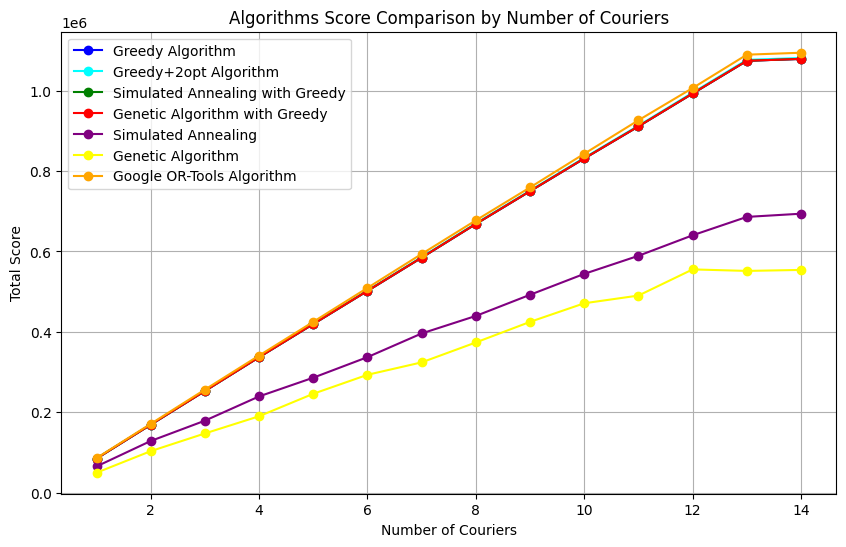

In [33]:
def plot_comparison(
    courier_range: range,
    greedy_costs: List[float],
    greedy_2opt_costs: List[float],
    sa_greedy_costs: List[float],
    ga_greedy_costs: List[float],
    sa_costs: List[float],
    ga_costs: List[float],
    vrp_costs: List[float],
):
    plt.figure(figsize=(10, 6))

    plt.plot(courier_range, greedy_costs, label="Greedy Algorithm", marker="o", color="blue",)
    plt.plot(
        courier_range, greedy_2opt_costs, label="Greedy+2opt Algorithm", marker="o",        color="cyan",

    )
    plt.plot(
        courier_range,
        sa_greedy_costs,
        label="Simulated Annealing with Greedy",
        marker="o",
        color="green"
    )
    plt.plot(
        courier_range,
        ga_greedy_costs,
        label="Genetic Algorithm with Greedy",
        marker="o",
        color="red"
    )
    plt.plot(courier_range, sa_costs, label="Simulated Annealing", marker="o", color="purple",)
    plt.plot(courier_range, ga_costs, label="Genetic Algorithm", marker="o", color="yellow",)
    plt.plot(courier_range, vrp_costs, label="Google OR-Tools Algorithm", marker="o", color="orange")

    plt.xlabel("Number of Couriers")
    plt.ylabel("Total Score")
    plt.title("Algorithms Score Comparison by Number of Couriers")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_comparison(
    range(1, NUM_COURIERS),
    greedy_costs,
    greedy_2opt_costs,
    sa_greedy_costs,
    ga_greedy_costs,
    sa_costs,
    ga_costs,
    vrp_costs,
)

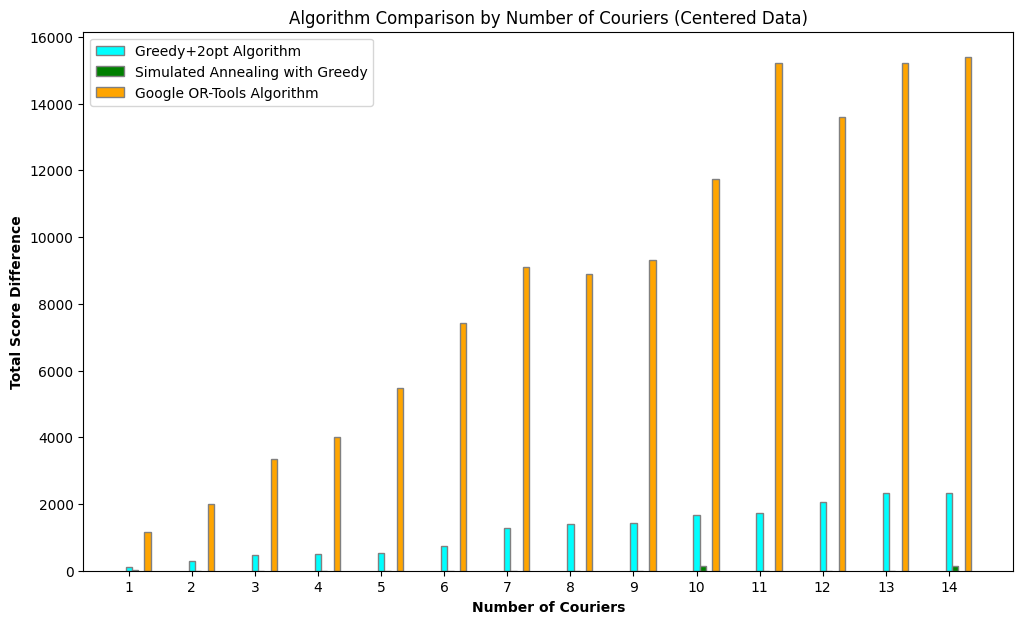

In [34]:
def plot_comparison(
    courier_range: range,
    greedy_costs: List[float],
    greedy_2opt_costs: List[float],
    sa_greedy_costs: List[float],
    ga_greedy_costs: List[float],
    vrp_costs: List[float],
):
    bar_width = 0.1

    r1 = np.arange(len(courier_range))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]

    plt.figure(figsize=(12, 7))

    # Centering the data on greedy_costs
    differences_2opt = [
        greedy_2opt_costs[i] - greedy_costs[i] for i in range(len(greedy_costs))
    ]
    differences_sa_greedy = [
        sa_greedy_costs[i] - greedy_costs[i] for i in range(len(greedy_costs))
    ]
    differences_vrp = [vrp_costs[i] - greedy_costs[i] for i in range(len(greedy_costs))]

    # Plotting the differences
    # plt.bar(r1, greedy_costs, color='blue', width=bar_width, edgecolor='grey', label='Greedy Algorithm')
    plt.bar(
        r2,
        differences_2opt,
        color="cyan",
        width=bar_width,
        edgecolor="grey",
        label="Greedy+2opt Algorithm",
    )
    plt.bar(
        r3,
        differences_sa_greedy,
        color="green",
        width=bar_width,
        edgecolor="grey",
        label="Simulated Annealing with Greedy",
    )
    plt.bar(
        r5,
        differences_vrp,
        color="orange",
        width=bar_width,
        edgecolor="grey",
        label="Google OR-Tools Algorithm",
    )

    plt.xlabel("Number of Couriers", fontweight="bold")
    plt.xticks([r + bar_width for r in range(len(courier_range))], courier_range)

    plt.ylabel("Total Score Difference", fontweight="bold")
    plt.title("Algorithm Comparison by Number of Couriers (Centered Data)")
    plt.legend()

    plt.show()


# Plotting the comparison

plot_comparison(
    range(1, NUM_COURIERS),
    greedy_costs,
    greedy_2opt_costs,
    sa_greedy_costs,
    ga_greedy_costs,
    vrp_costs,
)

In [22]:



sum([(vrp_costs[i] - greedy_2opt_costs[i])/(greedy_2opt_costs[i]) for i in range(1,len(greedy_2opt_costs))])/NUM_COURIERS

0.010109088175489729